In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for harem-ft_ELMo+Embeddings_fasttext_skip_0_0
25
25


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo+CNN', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'glove', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem', 'ELMo', '0', '0']
['harem', 'ELMo+CNN', '0', '0']
['harem', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem', 'ELMo+CNN+Embeddings', 'glove', '0', '0']
['harem', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0', '0']
['harem', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0', '0']
['harem', 'ELMo+CNN+Embed

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,16,20,00:29:28,1768.0,88.40,0.998086,0.998276,0.977568,0.975458,0.976512,3.587718,0.980767,0.983281,0.831266,0.854592,0.842767,82.332504,0.978867,0.980443,0.820000,0.807679,0.813793,93.089778
1,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,0,0,11,20,00:25:16,1516.0,75.80,0.997089,0.997336,0.968091,0.965480,0.966784,5.961578,0.980658,0.982953,0.822055,0.836735,0.829330,62.950836,0.977771,0.979572,0.819931,0.796661,0.808129,70.118833
2,harem-ft_ELMo+CNN+Embeddings_fasttext_skip_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,skip,0,0,18,20,00:24:52,1492.0,74.60,0.998690,0.998836,0.985672,0.983279,0.984474,2.842341,0.979128,0.980876,0.816626,0.852041,0.833958,94.846123,0.978912,0.980428,0.826356,0.804007,0.815028,102.920017
3,harem-ft_ELMo+CNN+Embeddings_glove_0_0,harem-ft,ELMo+CNN+Embeddings,glove,No,0,0,19,20,00:24:32,1472.0,73.60,0.998601,0.998757,0.983275,0.983010,0.983142,3.082004,0.981204,0.983062,0.814010,0.859694,0.836228,90.117733,0.977891,0.979482,0.811536,0.808013,0.809771,108.923202
4,harem-ft_ELMo+CNN+Embeddings_wang2vec_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,wang2vec,cbow,0,0,19,20,00:24:39,1479.0,73.95,0.998780,0.998858,0.985919,0.981931,0.983921,2.308520,0.980986,0.982734,0.810680,0.852041,0.830846,89.636565,0.978762,0.980383,0.823152,0.814357,0.818731,110.505644
5,harem-ft_ELMo+CNN+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+CNN+Embeddings,wang2vec,skip,0,0,19,20,00:24:42,1482.0,74.10,0.998679,0.998769,0.981681,0.982740,0.982210,2.891462,0.980767,0.982953,0.810680,0.852041,0.830846,88.034958,0.978371,0.979992,0.826903,0.808681,0.817691,104.945810
6,harem-ft_ELMo+CNN+Embeddings_word2vec_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,word2vec,cbow,0,0,19,20,00:23:44,1424.0,71.20,0.998970,0.999048,0.986006,0.988134,0.987069,2.345321,0.980658,0.982734,0.827411,0.831633,0.829517,94.144581,0.978477,0.980143,0.828681,0.792988,0.810442,113.365912
7,harem-ft_ELMo+CNN+Embeddings_word2vec_skip_0_0,harem-ft,ELMo+CNN+Embeddings,word2vec,skip,0,0,15,20,00:24:10,1450.0,72.50,0.999093,0.999149,0.988652,0.986785,0.987718,1.870523,0.979347,0.981751,0.842377,0.831633,0.836970,95.196834,0.978131,0.979887,0.842801,0.787646,0.814291,102.636813
8,harem-ft_ELMo+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+Embeddings,fasttext,cbow,0,0,19,20,00:26:09,1569.0,78.45,0.997000,0.997280,0.964218,0.959277,0.961741,5.754768,0.979893,0.981969,0.808354,0.839286,0.823529,65.361605,0.978582,0.980173,0.821647,0.806010,0.813754,77.815273
9,harem_ELMo_0_0,harem,ELMo,No,No,0,0,11,20,00:23:20,1400.0,70.00,0.997996,0.998153,0.978672,0.977616,0.978144,4.126267,0.978144,0.980439,0.817010,0.808673,0.812821,58.994444,0.977486,0.979347,0.829585,0.788314,0.808423,77.894849


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:24:07.600000'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']

def get_group_csv(group_name, group_columns, target_value, dataframe=training_data_df, exported_columns=default_exported_columns):
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_all_reps.csv', columns=exported_columns, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv(MODEL, MODEL, TEST_F1_MEASURE)

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
harem-ft,9.0,81.351428,0.353809,80.812870,0.810442,0.813793,0.815028,81.873112
harem,16.0,80.938065,0.731448,79.414298,0.807155,0.809485,0.813565,82.436070


In [14]:
get_group_csv(REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE)

,count,mean,std,min,25%,50%,75%,max
Representation,,,,,,,,
ELMo+CNN+Embeddings,14.0,81.263154,0.396296,80.694516,0.809939,0.812894,0.814844,81.873112
ELMo+Embeddings,8.0,80.981476,0.802006,79.836929,0.805937,0.809698,0.813569,82.436070
ELMo,1.0,80.842322,NaN,80.842322,0.808423,0.808423,0.808423,80.842322
ELMo+CNN,2.0,80.396804,1.389474,79.414298,0.799056,0.803968,0.808881,81.379310


In [15]:
get_group_csv(EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
skip,9.0,81.496926,0.479707,80.730841,0.812053,0.814291,0.817691,82.436070
No,6.0,80.889564,0.758045,79.414298,0.808760,0.811639,0.813679,81.379310
cbow,10.0,80.836218,0.569759,79.836929,0.807015,0.807894,0.810520,81.873112


In [16]:
get_group_csv(EMBEDDING, EMBEDDING, TEST_F1_MEASURE)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,6.0,81.462004,0.679610,80.722485,0.808758,0.814872,0.818471,82.436070
glove,3.0,81.233818,0.222634,80.977079,0.811639,0.813508,0.813622,81.373569
fasttext,7.0,81.010733,0.473585,80.182156,0.807719,0.810546,0.813959,81.502792
word2vec,6.0,80.997892,0.680689,79.836929,0.807819,0.811089,0.813652,81.808977
No,3.0,80.545310,1.015618,79.414298,0.801283,0.808423,0.811108,81.379310


In [17]:
get_group_csv('Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE)

count       mean  std  \
Model    Representation      Embedding Embedding_Type                          
harem    ELMo+Embeddings     wang2vec  skip              1.0  82.436070  NaN   
harem-ft ELMo+CNN+Embeddings wang2vec  cbow              1.0  81.873112  NaN   
harem    ELMo+CNN+Embeddings word2vec  skip              1.0  81.808977  NaN   
harem-ft ELMo+CNN+Embeddings wang2vec  skip              1.0  81.769075  NaN   
                             fasttext  skip              1.0  81.502792  NaN   
                             word2vec  skip              1.0  81.429065  NaN   
harem    ELMo+CNN+Embeddings fasttext  skip              1.0  81.416526  NaN   
harem-ft ELMo+CNN            No        No                1.0  81.379310  NaN   
         ELMo+Embeddings     fasttext  cbow              1.0  81.375358  NaN   
harem    ELMo+CNN+Embeddings glove     No                1.0  81.373569  NaN   
         ELMo+Embeddings     glove     No                1.0  81.350806  NaN   
         ELMo+CNN+Embeddings wang2vec  skip              1.0  81.205312  NaN   
         ELMo+Embeddings     word2vec  skip              1.0  81.173677  NaN   
         ELMo+CNN+Embeddings fasttext  cbow              1.0  81.054588  NaN   
harem-ft ELMo+CNN+Embeddings word2vec  cbow              1.0  81.044190  NaN   
                             glove     No                1.0  80.977079  NaN   
harem    ELMo                No        No                1.0  80.842322  NaN   
harem-ft ELMo+CNN+Embeddings fasttext  cbow              1.0  80.812870  NaN   
harem    ELMo+Embeddings     wang2vec  cbow              1.0  80.765972  NaN   
                             fasttext  skip              1.0  80.730841  NaN   
         ELMo+CNN+Embeddings wang2vec  cbow              1.0  80.722485  NaN   
                             word2vec  cbow              1.0  80.694516  NaN   
         ELMo+Embeddings     fasttext  cbow              1.0  80.182156  NaN   
                             word2vec  cbow              1.0  79.836929  NaN   
         ELMo+CNN            No        No                1.0  79.414298  NaN   

                                                             min       25%  \
Model    Representation      Embedding Embedding_Type                        
harem    ELMo+Embeddings     wang2vec  skip            82.436070  0.824361   
harem-ft ELMo+CNN+Embeddings wang2vec  cbow            81.873112  0.818731   
harem    ELMo+CNN+Embeddings word2vec  skip            81.808977  0.818090   
harem-ft ELMo+CNN+Embeddings wang2vec  skip            81.769075  0.817691   
                             fasttext  skip            81.502792  0.815028   
                             word2vec  skip            81.429065  0.814291   
harem    ELMo+CNN+Embeddings fasttext  skip            81.416526  0.814165   
harem-ft ELMo+CNN            No        No              81.379310  0.813793   
         ELMo+Embeddings     fasttext  cbow            81.375358  0.813754   
harem    ELMo+CNN+Embeddings glove     No              81.373569  0.813736   
         ELMo+Embeddings     glove     No              81.350806  0.813508   
         ELMo+CNN+Embeddings wang2vec  skip            81.205312  0.812053   
         ELMo+Embeddings     word2vec  skip            81.173677  0.811737   
         ELMo+CNN+Embeddings fasttext  cbow            81.054588  0.810546   
harem-ft ELMo+CNN+Embeddings word2vec  cbow            81.044190  0.810442   
                             glove     No              80.977079  0.809771   
harem    ELMo                No        No              80.842322  0.808423   
harem-ft ELMo+CNN+Embeddings fasttext  cbow            80.812870  0.808129   
harem    ELMo+Embeddings     wang2vec  cbow            80.765972  0.807660   
                             fasttext  skip            80.730841  0.807308   
         ELMo+CNN+Embeddings wang2vec  cbow            80.722485  0.807225   
                             word2vec  cbow            80.694516  0.806945   
         ELMo+Embeddin

In [18]:
training_data_df.groupby([MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean  std  \
Model    Representation      Embedding Embedding_Type                         
harem    ELMo+Embeddings     wang2vec  skip              1.0  0.824361  NaN   
harem-ft ELMo+CNN+Embeddings wang2vec  cbow              1.0  0.818731  NaN   
harem    ELMo+CNN+Embeddings word2vec  skip              1.0  0.818090  NaN   
harem-ft ELMo+CNN+Embeddings wang2vec  skip              1.0  0.817691  NaN   
                             fasttext  skip              1.0  0.815028  NaN   
                             word2vec  skip              1.0  0.814291  NaN   
harem    ELMo+CNN+Embeddings fasttext  skip              1.0  0.814165  NaN   
harem-ft ELMo+CNN            No        No                1.0  0.813793  NaN   
         ELMo+Embeddings     fasttext  cbow              1.0  0.813754  NaN   
harem    ELMo+CNN+Embeddings glove     No                1.0  0.813736  NaN   
         ELMo+Embeddings     glove     No                1.0  0.813508  NaN   
         ELMo+CNN+Embeddings wang2vec  skip              1.0  0.812053  NaN   
         ELMo+Embeddings     word2vec  skip              1.0  0.811737  NaN   
         ELMo+CNN+Embeddings fasttext  cbow              1.0  0.810546  NaN   
harem-ft ELMo+CNN+Embeddings word2vec  cbow              1.0  0.810442  NaN   
                             glove     No                1.0  0.809771  NaN   
harem    ELMo                No        No                1.0  0.808423  NaN   
harem-ft ELMo+CNN+Embeddings fasttext  cbow              1.0  0.808129  NaN   
harem    ELMo+Embeddings     wang2vec  cbow              1.0  0.807660  NaN   
                             fasttext  skip              1.0  0.807308  NaN   
         ELMo+CNN+Embeddings wang2vec  cbow              1.0  0.807225  NaN   
                             word2vec  cbow              1.0  0.806945  NaN   
         ELMo+Embeddings     fasttext  cbow              1.0  0.801822  NaN   
                             word2vec  cbow              1.0  0.798369  NaN   
         ELMo+CNN            No        No                1.0  0.794143  NaN   

                                                            min       25%  \
Model    Representation      Embedding Embedding_Type                       
harem    ELMo+Embeddings     wang2vec  skip            0.824361  0.824361   
harem-ft ELMo+CNN+Embeddings wang2vec  cbow            0.818731  0.818731   
harem    ELMo+CNN+Embeddings word2vec  skip            0.818090  0.818090   
harem-ft ELMo+CNN+Embeddings wang2vec  skip            0.817691  0.817691   
                             fasttext  skip            0.815028  0.815028   
                             word2vec  skip            0.814291  0.814291   
harem    ELMo+CNN+Embeddings fasttext  skip            0.814165  0.814165   
harem-ft ELMo+CNN            No        No              0.813793  0.813793   
         ELMo+Embeddings     fasttext  cbow            0.813754  0.813754   
harem    ELMo+CNN+Embeddings glove     No              0.813736  0.813736   
         ELMo+Embeddings     glove     No              0.813508  0.813508   
         ELMo+CNN+Embeddings wang2vec  skip            0.812053  0.812053   
         ELMo+Embeddings     word2vec  skip            0.811737  0.811737   
         ELMo+CNN+Embeddings fasttext  cbow            0.810546  0.810546   
harem-ft ELMo+CNN+Embeddings word2vec  cbow            0.810442  0.810442   
                             glove     No              0.809771  0.809771   
harem    ELMo                No        No              0.808423  0.808423   
harem-ft ELMo+CNN+Embeddings fasttext  cbow            0.808129  0.808129   
harem    ELMo+Embeddings     wang2vec  cbow            0.807660  0.807660   
                             fasttext  skip            0.807308  0.807308   
         ELMo+CNN+Embeddings wang2vec  cbow            0.807225  0.807225   
                             word2vec  cbow            0.806945  0.806945   
         ELMo+Embeddings     fasttext  cbow            0.801822  0.801822

In [19]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,3.0,0.818035,0.006161,0.812053,0.814872,0.817691,0.821026,0.824361
word2vec,skip,3.0,0.814706,0.003197,0.811737,0.813014,0.814291,0.816190,0.818090
glove,No,3.0,0.812338,0.002226,0.809771,0.811639,0.813508,0.813622,0.813736
fasttext,skip,3.0,0.812167,0.004230,0.807308,0.810737,0.814165,0.814597,0.815028
wang2vec,cbow,3.0,0.811205,0.006521,0.807225,0.807442,0.807660,0.813195,0.818731
fasttext,cbow,4.0,0.808562,0.005050,0.801822,0.806552,0.809337,0.811348,0.813754
No,No,3.0,0.805453,0.010156,0.794143,0.801283,0.808423,0.811108,0.813793
word2vec,cbow,3.0,0.805252,0.006212,0.798369,0.802657,0.806945,0.808694,0.810442


In [20]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,16,20,00:29:28,1768.0,88.40,0.998086,0.998276,0.977568,0.975458,0.976512,3.587718,0.980767,0.983281,0.831266,0.854592,0.842767,82.332504,0.978867,0.980443,0.820000,0.807679,0.813793,93.089778
2,harem-ft_ELMo+CNN+Embeddings_fasttext_skip_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,skip,0,0,18,20,00:24:52,1492.0,74.60,0.998690,0.998836,0.985672,0.983279,0.984474,2.842341,0.979128,0.980876,0.816626,0.852041,0.833958,94.846123,0.978912,0.980428,0.826356,0.804007,0.815028,102.920017
3,harem-ft_ELMo+CNN+Embeddings_glove_0_0,harem-ft,ELMo+CNN+Embeddings,glove,No,0,0,19,20,00:24:32,1472.0,73.60,0.998601,0.998757,0.983275,0.983010,0.983142,3.082004,0.981204,0.983062,0.814010,0.859694,0.836228,90.117733,0.977891,0.979482,0.811536,0.808013,0.809771,108.923202
5,harem-ft_ELMo+CNN+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+CNN+Embeddings,wang2vec,skip,0,0,19,20,00:24:42,1482.0,74.10,0.998679,0.998769,0.981681,0.982740,0.982210,2.891462,0.980767,0.982953,0.810680,0.852041,0.830846,88.034958,0.978371,0.979992,0.826903,0.808681,0.817691,104.945810
7,harem-ft_ELMo+CNN+Embeddings_word2vec_skip_0_0,harem-ft,ELMo+CNN+Embeddings,word2vec,skip,0,0,15,20,00:24:10,1450.0,72.50,0.999093,0.999149,0.988652,0.986785,0.987718,1.870523,0.979347,0.981751,0.842377,0.831633,0.836970,95.196834,0.978131,0.979887,0.842801,0.787646,0.814291,102.636813
9,harem_ELMo_0_0,harem,ELMo,No,No,0,0,11,20,00:23:20,1400.0,70.00,0.997996,0.998153,0.978672,0.977616,0.978144,4.126267,0.978144,0.980439,0.817010,0.808673,0.812821,58.994444,0.977486,0.979347,0.829585,0.788314,0.808423,77.894849
10,harem_ELMo+CNN_0_0,harem,ELMo+CNN,No,No,0,0,17,20,00:23:47,1427.0,71.35,0.998086,0.998209,0.977334,0.976807,0.977070,3.945563,0.979128,0.981969,0.821883,0.823980,0.822930,76.456795,0.976856,0.978897,0.820285,0.769616,0.794143,106.280498
12,harem_ELMo+CNN+Embeddings_fasttext_skip_0_0,harem,ELMo+CNN+Embeddings,fasttext,skip,0,0,17,20,00:24:10,1450.0,72.50,0.998914,0.998981,0.987318,0.986785,0.987052,2.546832,0.980439,0.982625,0.812195,0.849490,0.830424,73.006343,0.978326,0.980263,0.822487,0.806010,0.814165,98.920831
13,harem_ELMo+CNN+Embeddings_glove_0_0,harem,ELMo+CNN+Embeddings,glove,No,0,0,13,20,00:24:08,1448.0,72.40,0.998925,0.999004,0.984918,0.986246,0.985581,2.145470,0.977707,0.980549,0.839895,0.816327,0.827943,76.999087,0.977216,0.979242,0.846626,0.783306,0.813736,98.657610
15,harem_ELMo+CNN+Embeddings_wang2vec_skip_0_0,harem,ELMo+CNN+Embeddings,wang2vec,skip,0,0,15,20,00:24:16,1456.0,72.80,0.998724,0.998813,0.984341,0.983279,0.983810,2.221223,0.979784,0.981860,0.820197,0.849490,0.834586,79.313391,0.978522,0.980308,0.828413,0.796327,0.812053,93.470976


In [21]:
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,3.0,0.818035,0.006161,0.812053,0.814872,0.817691,0.821026,0.824361
word2vec,3.0,0.814706,0.003197,0.811737,0.813014,0.814291,0.816190,0.818090
glove,3.0,0.812338,0.002226,0.809771,0.811639,0.813508,0.813622,0.813736
fasttext,3.0,0.812167,0.004230,0.807308,0.810737,0.814165,0.814597,0.815028
No,3.0,0.805453,0.010156,0.794143,0.801283,0.808423,0.811108,0.813793


In [22]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,16,20,00:29:28,1768.0,88.40,0.998086,0.998276,0.977568,0.975458,0.976512,3.587718,0.980767,0.983281,0.831266,0.854592,0.842767,82.332504,0.978867,0.980443,0.820000,0.807679,0.813793,93.089778
1,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,0,0,11,20,00:25:16,1516.0,75.80,0.997089,0.997336,0.968091,0.965480,0.966784,5.961578,0.980658,0.982953,0.822055,0.836735,0.829330,62.950836,0.977771,0.979572,0.819931,0.796661,0.808129,70.118833
3,harem-ft_ELMo+CNN+Embeddings_glove_0_0,harem-ft,ELMo+CNN+Embeddings,glove,No,0,0,19,20,00:24:32,1472.0,73.60,0.998601,0.998757,0.983275,0.983010,0.983142,3.082004,0.981204,0.983062,0.814010,0.859694,0.836228,90.117733,0.977891,0.979482,0.811536,0.808013,0.809771,108.923202
4,harem-ft_ELMo+CNN+Embeddings_wang2vec_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,wang2vec,cbow,0,0,19,20,00:24:39,1479.0,73.95,0.998780,0.998858,0.985919,0.981931,0.983921,2.308520,0.980986,0.982734,0.810680,0.852041,0.830846,89.636565,0.978762,0.980383,0.823152,0.814357,0.818731,110.505644
6,harem-ft_ELMo+CNN+Embeddings_word2vec_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,word2vec,cbow,0,0,19,20,00:23:44,1424.0,71.20,0.998970,0.999048,0.986006,0.988134,0.987069,2.345321,0.980658,0.982734,0.827411,0.831633,0.829517,94.144581,0.978477,0.980143,0.828681,0.792988,0.810442,113.365912
8,harem-ft_ELMo+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+Embeddings,fasttext,cbow,0,0,19,20,00:26:09,1569.0,78.45,0.997000,0.997280,0.964218,0.959277,0.961741,5.754768,0.979893,0.981969,0.808354,0.839286,0.823529,65.361605,0.978582,0.980173,0.821647,0.806010,0.813754,77.815273
9,harem_ELMo_0_0,harem,ELMo,No,No,0,0,11,20,00:23:20,1400.0,70.00,0.997996,0.998153,0.978672,0.977616,0.978144,4.126267,0.978144,0.980439,0.817010,0.808673,0.812821,58.994444,0.977486,0.979347,0.829585,0.788314,0.808423,77.894849
10,harem_ELMo+CNN_0_0,harem,ELMo+CNN,No,No,0,0,17,20,00:23:47,1427.0,71.35,0.998086,0.998209,0.977334,0.976807,0.977070,3.945563,0.979128,0.981969,0.821883,0.823980,0.822930,76.456795,0.976856,0.978897,0.820285,0.769616,0.794143,106.280498
11,harem_ELMo+CNN+Embeddings_fasttext_cbow_0_0,harem,ELMo+CNN+Embeddings,fasttext,cbow,0,0,17,20,00:24:58,1498.0,74.90,0.996843,0.997145,0.967146,0.960626,0.963875,6.382357,0.979456,0.981751,0.807317,0.844388,0.825436,64.810102,0.977906,0.979632,0.820671,0.800668,0.810546,75.042944
13,harem_ELMo+CNN+Embeddings_glove_0_0,harem,ELMo+CNN+Embeddings,glove,No,0,0,13,20,00:24:08,1448.0,72.40,0.998925,0.999004,0.984918,0.986246,0.985581,2.145470,0.977707,0.980549,0.839895,0.816327,0.827943,76.999087,0.977216,0.979242,0.846626,0.783306,0.813736,98.657610


In [23]:
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,3.0,0.812338,0.002226,0.809771,0.811639,0.813508,0.813622,0.813736
wang2vec,3.0,0.811205,0.006521,0.807225,0.807442,0.807660,0.813195,0.818731
fasttext,4.0,0.808562,0.005050,0.801822,0.806552,0.809337,0.811348,0.813754
No,3.0,0.805453,0.010156,0.794143,0.801283,0.808423,0.811108,0.813793
word2vec,3.0,0.805252,0.006212,0.798369,0.802657,0.806945,0.808694,0.810442


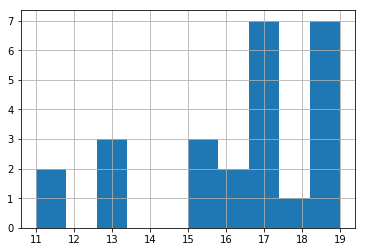

In [24]:
training_data_df[BEST_EPOCH].hist()

In [25]:
training_data_df[TOTAL_DURATION].describe()

count      25.0
mean     1447.6
std        89.0
min      1333.0
25%      1400.0
50%      1448.0
75%      1479.0
max      1768.0
Name: Total_Duration(s), dtype: float64

In [26]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,25.0,0.810869,0.006458,0.794143,0.80766,0.811737,0.814165,0.824361


In [27]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,25.0,0.810869,0.006458,0.001292,0.808203,0.813535


In [28]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,3,0.805453,0.010156,0.005864,0.793960,0.816946
fasttext,7,0.810107,0.004736,0.001790,0.806599,0.813616
glove,3,0.812338,0.002226,0.001285,0.809819,0.814858
wang2vec,6,0.814620,0.006796,0.002774,0.809182,0.820058
word2vec,6,0.809979,0.006807,0.002779,0.804532,0.815426


In [29]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [30]:
print_anova(EMBEDDING)

Overall model F( 4, 20) =  1.154, p =  0.36046132675486497465
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.154
Date:                Tue, 28 May 2019   Prob (F-statistic):              0.360
Time:                        21:16:41   Log-Likelihood:                 93.691
No. Observations:                  25   AIC:                            -177.4
Df Residuals:                      20   BIC:                            -171.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------